<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FinalEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image, ImageOps
import sys
import statistics


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 72 kB 820 kB/s 
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Mounted at /content/drive


#**Preparation for SeqNet**

In [2]:
IMG_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00265140_00_2L.jpg"

In [10]:
#GithubよりSeqNetをcloneする
os.chdir('/content')
!git clone https://github.com/conscienceli/SeqNet.git

#出力用フォルダを作る
output_path = "/content/SeqNet/SeqNet_output"
os.makedirs(output_path, exist_ok=True)

#作業ディレクトリをpathに移動する
os.chdir('/content/SeqNet')
#評価画像用のフォルダを作成
data_dir = "./data/test_images/"
os.makedirs(data_dir, exist_ok=True)

#Download pretrained model from Gdrive
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1OYjzu0gixtga6e7Rvb2mZoSSYJkXWRNB'

os.makedirs('./trained_model/ALL', exist_ok=True)
destination = './trained_model/ALL/Final_Emer_Iteration_3_cropsize_128_epochs_200.hdf5'
download_file_from_google_drive(file_id, destination)


#upgrade modules
!pip3 install --upgrade tensorflow==1.15.0
!pip3 install --upgrade keras==2.3.1
!pip3 install --upgrade h5py==2.10.0


"""
これを走らせる前に、predict.pyを置換する。
・artery, vein finalを削除
・出力ファイル形式を.jpgに変更
・stride_sizeを10に変更（メモリ節約のため）
"""
shutil.copy("/content/drive/MyDrive/Deep_learning/FundusPhoto/SeqNet/predict.py", "/content/SeqNet/predict.py")

fatal: destination path 'SeqNet' already exists and is not an empty directory.


'/content/SeqNet/predict.py'

In [23]:
def Mirror_left_eye(pil_img, img_path):
    filename = os.path.splitext(IMG_PATH)[0]
    side = filename[-1]
    if side == "R":
        flipped_img = pil_img
    elif side == "L":
        img_mirror = ImageOps.mirror(pil_img)
        flipped_img = img_mirror
    return flipped_img

def crop2square(pil_img):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = pil_img.crop(((width-height)//2, 0, (width+height)//2, height))
        return result
    else:
        result = pil_img.crop((0, (height-width)//2, width, (height+width)//2))
        return result

def crop_disc(pil_img):
    width, height = pil_img.size
    if width % 10 != 0:
        print("幅を10等分できません")
    if height % 10 != 0:
        print("高さを10等分できません")
    x_axis = int(width/10)
    y_axis = int(height/10)
    disc_img = pil_img.crop((5*x_axis, 3*y_axis, 9*x_axis, 7*y_axis))
    return disc_img

def crop_macula(pil_img):
    width, height = pil_img.size
    if width % 20 != 0:
        print("幅を5等分できません")
    if height % 20 != 0:
        print("高さを5等分できません")
    x_axis = int(width/20)
    y_axis = int(height/20)

    macula_img = pil_img.crop((4*x_axis, 7*y_axis, 10*x_axis, 13*y_axis))
    return macula_img



In [25]:
orig_img = Image.open(IMG_PATH)
flipped_img = Mirror_left_eye(orig_img, IMG_PATH)
cropped_img = crop2square(flipped_img)
disc_img = crop_disc(cropped_img)
macula_img = crop_macula(cropped_img)

###SeqNet用の下準備

SeqNet_PATH = '/content/SeqNet/'
#作業ディレクトリをpathに移動する
os.chdir(SeqNet_PATH)
#評価画像用のフォルダを作成
cropped_img.save(data_dir + "temp.jpg")
!python predict.py -i /content/SeqNet/data/test_images/ -o /content/SeqNet/SeqNet_output/
vascular_img = Image.open("/content/SeqNet/SeqNet_output/out_seg/temp.jpg")

Using TensorFlow backend.



2021-09-28 04:14:35.850414: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-28 04:14:35.856388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-09-28 04:14:35.858071: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b68c342a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-28 04:14:35.858107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-28 04:14:35.860036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-28 04:14:35.870374: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-28 04:14:35.870414: I tensorflow/stream_executor/

In [ ]:
#画像の読み込み
#im = Image.open(IMG_PATH)
#画像をarrayに変換
im_list = np.asarray(vascular_img)
#軸を非表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.tick_params(bottom=False, left=False, right=False, top=False)
#貼り付け
plt.gray()
plt.imshow(im_list)
#表示
#plt.show()


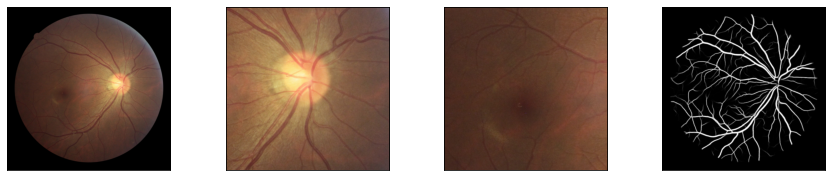

In [36]:
def show_img(im_list):
    plt.figure(figsize=(15, 3))
    for i in range(len(im_list)):
        image = im_list[i]
        #image = image.permute(1, 2, 0)
        plt.subplot(1, 4, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)
        

#画像の可視化
im_list = [cropped_img, disc_img, macula_img, vascular_img]
show_img(im_list)


In [ ]:
#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0] == image_name].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft): 
    output = model_ft(image_tensor).item()*100
    return output